# Example 3: Dark Matter

In this example we'll consider a more scientifically motivated problem. Astrophysically, dark matter is observed to fall into spherically symmetric arrangements called "haloes". As a function of spherical radius $r$, the density profile of a halo is typically taken to be the Navarro-Frenk-White (NFW) profile:
$$\rho(r) = \dfrac{\rho_0}{\dfrac{r}{r_s}\left(1 + \dfrac{r}{r_s}\right)^2}$$

This is a 2-parameter profile, with a density scaling $\rho_0$ serving as a normalisation, and a scale radius $r_s$. This is essentially double power law: $\rho \propto r^{-1}$ where $r \ll r_s$ and $\rho \propto r^{-3}$ where $r \gg r_s$.

For the Milky Way, reasonable values are $\rho_0 \approx 4 \times 10^{-22}~\mathrm{kg/m^3} \approx 0.006~\mathrm{M}_\odot / \mathrm{pc}^3$ and $r_s \approx 6 \times 10^{20}~\mathrm{m}\approx 20~\mathrm{kpc}$. We don't need to worry so much about $\rho_0$ as it simply sets the overall normalisation. 

In our case, we'll place 2 such haloes in a 3D box and sample some dark matter particles.

It's worth noting that the mass of the NFW profile is divergent unless cut off at some radius. The choice of this radius is a slightly thorny issue, but we'll just say that the density cuts to zero at $10 r_s$.

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

## NFW density

Function to evaluate density as function of position and halo parameters. A thing  to note here is the `q + 1e-3` in the denominator of the density, which didn't appear in the equation above. This is a way to deal with the divergence at $r=0$: this way when $r \ll r_s$, the density approaches a constant $\rho \rightarrow \rho(r=10^{-3}r_s)$.

In [4]:
def NFW_density(X, rho_0, r_s):
    r = np.linalg.norm(X, axis=-1)
    q = r / r_s
    rho = rho_0 / ((q + 1e-3) * (1 + q)**2)
    m = q > 10
    rho[m] = 0
    return rho

We'll also create some functions to create sampling cells for us. For each halo, we'll set up two concentric grids centred on the halo centre. First, an outer 128x128x128 grid from $-10r_s$ to $10r_s$. The central 32^3 cells are cleared out from this and replaced with a 256^3 grid. The function `generate_halo_grid` constructs these grids, evaluates the densities on the grid corners, then returns the things we'll need for `sample`:
- `x0`: A 2D array ($N_\mathrm{cells} \times 3$) of the coordinates of the 'first' corner of each cell
- `x1`: like `x0` but for the last corner of each cell
- `f`: a length-8 tuple of 1D arrays (each length $N_\mathrm{cells}$), representing the corner densities of each cell.

Here $N_\mathrm{cells}$ is the total number of cells, so $128^3 - 32^3 + 256^3 = 18841600$.

In [5]:
def generate_halo_grid(centre, rho_0, r_s):

    # grid sizes: outer grid is 128^3, but central 32^3 replaced with 256^3
    N_outer = 128
    N_inner = 256

    # set up outer grid
    h = 10 * r_s
    Xedges = np.linspace(centre[0] - h, centre[0] + h, N_outer + 1)
    Yedges = np.linspace(centre[1] - h, centre[1] + h, N_outer + 1)
    Zedges = np.linspace(centre[2] - h, centre[2] + h, N_outer + 1)
    corners = np.stack(np.meshgrid(Xedges, Yedges, Zedges, indexing='ij'), axis=-1)
    
    # evaluate densities on corners
    f = get_corner_densities(corners - centre, rho_0, r_s)

    # get coords of first and last corner
    x0 = corners[:-1, :-1, :-1].reshape((N_outer**3, 3))
    x1 = corners[1:, 1:, 1:].reshape((N_outer**3, 3))
    
    # remove central part of grid (to be replaced with inner grid)
    m = np.ones((N_outer, N_outer, N_outer), dtype=bool)
    i0 = 3 * N_outer // 8
    i1 = 5 * N_outer // 8
    m[i0:i1, i0:i1, i0:i1] = False
    m = m.flatten()
    f = tuple([fi[m] for fi in f])
    x0 = x0[m]
    x1 = x1[m]

    # set up inner grid
    Xedges = np.linspace(Xedges[i0], Xedges[i1], N_inner + 1)
    Yedges = np.linspace(Yedges[i0], Yedges[i1], N_inner + 1)
    Zedges = np.linspace(Zedges[i0], Zedges[i1], N_inner + 1)
    corners = np.stack(np.meshgrid(Xedges, Yedges, Zedges, indexing='ij'), axis=-1)

    # evaluate densities on corners
    f_inner = get_corner_densities(corners - centre, rho_0, r_s)

    # get coords of first and last corners
    x0_inner = corners[:-1, :-1, :-1].reshape((N_inner**3, 3))
    x1_inner = corners[1:, 1:, 1:].reshape((N_inner**3, 3))

    # concat inner and outer grids (densities and coords)
    f = tuple([np.hstack((f[i], f_inner[i])) for i in range(8)])
    x0 = np.vstack((x0, x0_inner))
    x1 = np.vstack((x1, x1_inner))
    
    return x0, x1, f

def get_corner_densities(corners, rho_0, r_s):
    f = NFW_density(corners, rho_0=rho_0, r_s=r_s)
    f000 = f[:-1, :-1, :-1].flatten()
    f001 = f[:-1, :-1, 1:].flatten()
    f010 = f[:-1, 1:, :-1].flatten()
    f011 = f[:-1, 1:, 1:].flatten()
    f100 = f[1:, :-1, :-1].flatten()
    f101 = f[1:, :-1, 1:].flatten()
    f110 = f[1:, 1:, :-1].flatten()
    f111 = f[1:, 1:, 1:].flatten()
    return f000, f001, f010, f011, f100, f101, f110, f111



## `sample`

Let's do two haloes at different locations, both with scale radii of 0.5 (we could call the units kpc, but really the code is agnostic), but with differing values of $\rho_0$. As it just sets a normalisation, we don't actually need to worry about the precise value of $\rho_0$, only the relative values between the two haloes. The total halo mass is proportional to $\rho_0$, so we'll give one halo twice the $\rho_0$ of the other and recheck later that it got twice the particles.

In [6]:
x0_0, x1_0, f_0 = generate_halo_grid(np.array([0.5, -2.5, 3.0]), 1.0, 0.5)
x0_1, x1_1, f_1 = generate_halo_grid(np.array([-2.5, -2.0, -5.5]), 2.0, 0.5)

Now we'll combine the cell coordinates and densities. It's worth noting that the grid cells from one halo might overlap with those of the other. This doesn't matter! It just means samples might appear in the same region of space via different grid cells, but the total probability across space will still integrate to 1.

In [7]:

x0 = np.vstack((x0_0, x0_1))
x1 = np.vstack((x1_0, x1_1))
f = tuple([np.hstack((f_0[i], f_1[i])) for i in range(8)])

Import `sample`

In [8]:
from lintsampler import sample

Draw samples

In [9]:
X = sample(x0, x1, *f, N_samples=10000000)

Let's visualise the samples with a histogram.

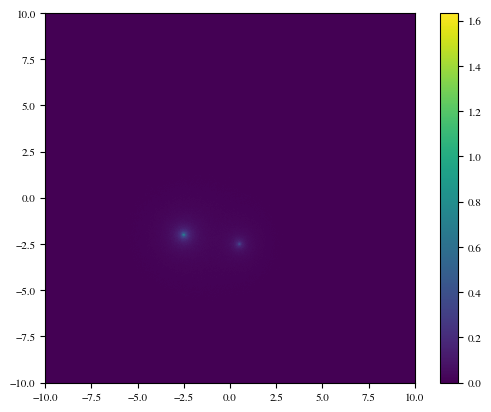

In [10]:
plt.hist2d(X[:, 0], X[:, 1], bins=np.linspace(-10, 10, 1000), density=True)
plt.gca().set_aspect('equal', adjustable='box')

plt.colorbar();

This doesn't look particularly impressive. The thing is that power law functions like the NFW profile have a vast dynamic range, so plotting density in linear space will show you the peak and not much else. Let's instead use a log-scale colour map:

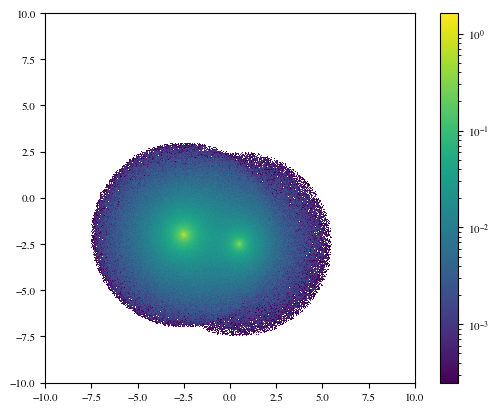

In [11]:
plt.hist2d(X[:, 0], X[:, 1], bins=np.linspace(-10, 10, 1000), density=True, norm=LogNorm())
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar();

We can see now that the haloes appear to overlap considerably, at least in $x$ and $y$. However, if we choose a different projection, e.g. $x-z$:

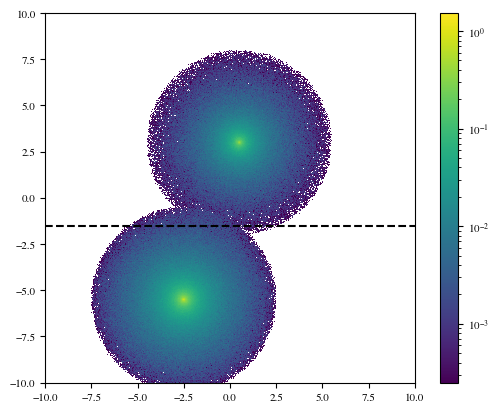

In [12]:
plt.hist2d(X[:, 0], X[:, 2], bins=np.linspace(-10, 10, 1000), density=True, norm=LogNorm())
plt.plot([-10, 10], [-1.5, -1.5], c='k', ls='dashed')
plt.xlim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar();

Still some overlap, but overall the haloes seem to separate much more cleanly in $z$. We can use this to test whether an appropriate number of particles has been sampled in each halo. The lower halo in this plot has twice the mass of the upper halo (because its $\rho_0$ parameter was doubled), so it should have twice the particles. If we take a horizontal line at $z=-1.25$ (the dashed line in the plot), then virtually all of the particles above/below the line will belong to the upper/lower halo (with some cross-contamination).

In [13]:
m = X[:, 2] > -1.25
print(f"Upper halo fraction: {m.sum() / len(m): .3f}")
print(f"Lower halo fraction: {1 - m.sum() / len(m): .3f}")


Upper halo fraction:  0.335
Lower halo fraction:  0.665


Looks great!